/home/giacomo/myenv/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1471: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


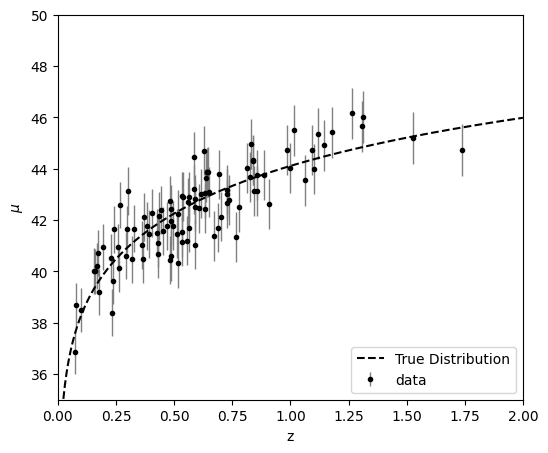

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import generate_mu_z
from astropy.cosmology import LambdaCDM
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
xgrid = np.linspace(0,2,1000)
mu_true = cosmo.distmod(xgrid)

fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
ax.plot(xgrid, mu_true,linestyle='--',marker='',color='black',label='True Distribution')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

In [2]:
from sklearn.model_selection import train_test_split

z_train, z_test, mu_train, mu_test, dmu_train, dmu_test = train_test_split(
    z_sample, mu_sample, dmu, test_size=0.2, random_state=42
)

z_train = z_train[:, np.newaxis]
z_test = z_test[:, np.newaxis]

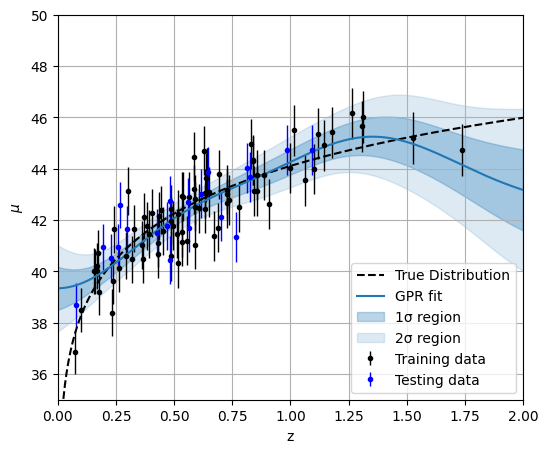

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# let's try a fit using GPR (we create a pipeline in order to also rescale the datas)

GPR = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(
        alpha=dmu_train**2,
        n_restarts_optimizer=10,
        normalize_y=True
    )
)
GPR.fit(z_train, mu_train)

ypred, ystd = GPR.predict(xgrid[:, np.newaxis], return_std=True)

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_test, mu_test, dmu_test, fmt='.b', lw=1, label='Testing data')
ax.plot(xgrid, mu_true,linestyle='--',marker='',color='black',label='True Distribution')
ax.plot(xgrid,ypred,color='C0',marker='',linestyle='-',label='GPR fit')
ax.fill_between(xgrid, ypred - ystd, ypred + ystd,
                alpha=0.3, color='C0', label='1σ region')
ax.fill_between(xgrid, ypred - 2 * ystd, ypred + 2 * ystd,
                alpha=0.15, color='C0', label='2σ region')

ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.grid(True)
ax.legend(loc='lower right')

/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


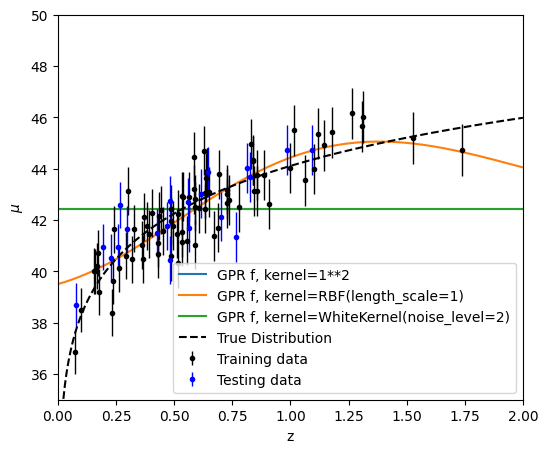

In [5]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

# let's try with some generic kernel taken individually
kernels=[ConstantKernel(1.0),RBF(length_scale=1.0, length_scale_bounds=(1e0, 1e3)),WhiteKernel(noise_level=2)]

fig,ax = plt.subplots(1,1,figsize=(6,5))
for k in kernels:
    GPR = make_pipeline(
        StandardScaler(),
        GaussianProcessRegressor(
            kernel=k,
            alpha=dmu_train**2,
            n_restarts_optimizer=10,
            normalize_y=True
        )
    )
    GPR.fit(z_train, mu_train)

    ypred, ystd = GPR.predict(xgrid[:, np.newaxis], return_std=True)
    ax.plot(xgrid,ypred,marker='',linestyle='-',label='GPR f, kernel='+str(k))
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_test, mu_test, dmu_test, fmt='.b', lw=1, label='Testing data')
ax.plot(xgrid, mu_true,linestyle='--',marker='',color='black',label='True Distribution')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


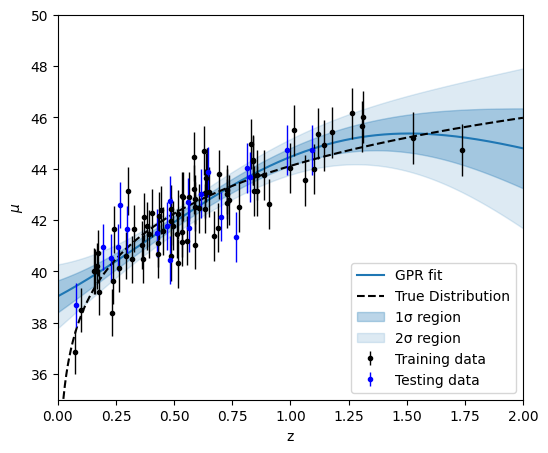

In [6]:
# now let's use a combination of those, it looks pretty nice
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel()
fig,ax = plt.subplots(1,1,figsize=(6,5))
GPR = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(
        kernel=kernel,
        alpha=dmu_train**2,
        n_restarts_optimizer=10,
        normalize_y=True
    )
)
GPR.fit(z_train, mu_train)

ypred, ystd = GPR.predict(xgrid[:, np.newaxis], return_std=True)
ax.plot(xgrid,ypred,marker='',linestyle='-',label='GPR fit')
ax.plot(xgrid,mu_true,linestyle='--',marker='',color='black',label='True Distribution')

ax.fill_between(xgrid, ypred - ystd, ypred + ystd,
                alpha=0.3, color='C0', label='1σ region')
ax.fill_between(xgrid, ypred - 2 * ystd, ypred + 2 * ystd,
                alpha=0.15, color='C0', label='2σ region')
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_test, mu_test, dmu_test, fmt='.b', lw=1, label='Testing data')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


# let's optimize the kernel by doing a cross validation
N=10
param_grid = {'kernel__k1__k2__length_scale': np.linspace(0.01, 0.2, 8)}  # k2 = RBF, k1 = ConstantKernel

# Kernel base: C * RBF
kernel = ConstantKernel(1.0, (1e-6, 1e6)) * RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e6)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-6, 1e1))

# note that in this case we don't put alpha because GridSearchCV doesn't divide them as it does with the y values
gpr = make_pipeline(
    StandardScaler(),
    GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,
        normalize_y=True
    )
)

param_grid = {
    'gaussianprocessregressor__kernel__k1__k1__constant_value': [0.1, 1.0, 10.0],
    'gaussianprocessregressor__kernel__k1__k2__length_scale': [0.1, 1.0, 10.0],
    'gaussianprocessregressor__kernel__k2__noise_level': [1e-5, 1e-3, 1e-1, 1.0]
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearchCV
grid = GridSearchCV(gpr, param_grid, cv=5, scoring=scorer)

grid.fit(z_train, mu_train)
print("Best parameters:", grid.best_params_)

/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/giacomo/myenv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best parameters: {'gaussianprocessregressor__kernel__k1__k1__constant_value': 1.0, 'gaussianprocessregressor__kernel__k1__k2__length_scale': 0.1, 'gaussianprocessregressor__kernel__k2__noise_level': 1e-05}


Score on the test dataset: -0.8798597445042393


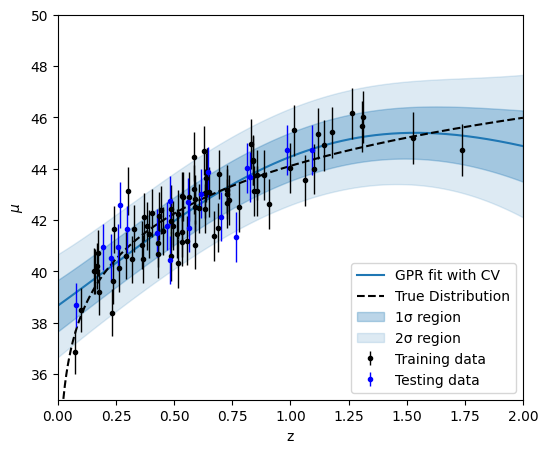

In [8]:
print(f'Score on the test dataset: {grid.score(z_test,y=mu_test)}')
fig,ax=plt.subplots(1,1,figsize=(6,5))
ypred, ystd = grid.best_estimator_.predict(xgrid[:,np.newaxis], return_std=True)
ax.plot(xgrid,ypred,marker='',linestyle='-',label='GPR fit with CV')
ax.plot(xgrid,mu_true,linestyle='--',marker='',color='black',label='True Distribution')

ax.fill_between(xgrid, ypred - ystd, ypred + ystd,
                alpha=0.3, color='C0', label='1σ region')
ax.fill_between(xgrid, ypred - 2 * ystd, ypred + 2 * ystd,
                alpha=0.15, color='C0', label='2σ region')
ax.errorbar(z_train, mu_train, dmu_train, fmt='.k', lw=1, label='Training data')
ax.errorbar(z_test, mu_test, dmu_test, fmt='.b', lw=1, label='Testing data')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

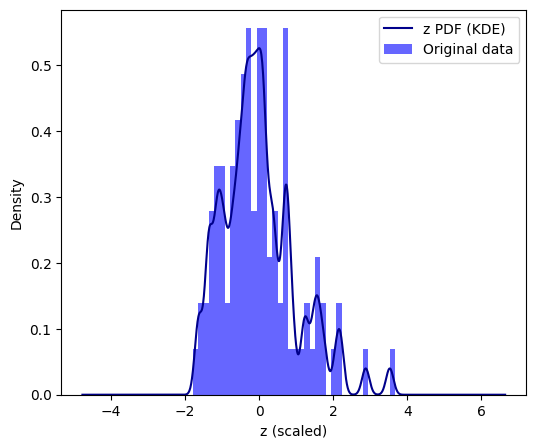

In [17]:
from sklearn.neighbors import KernelDensity
# let's use KDE in order to sample the distribution and create new data

Nbins = 50
z_vals = np.array(z_sample).reshape(-1, 1)
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z_vals)

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_scaled)

z_plot_orig = np.linspace(z_vals.min() - 1, z_vals.max() + 1, 1000).reshape(-1, 1)
z_plot_scaled = scaler.transform(z_plot_orig)

log_dens = kde.score_samples(z_plot_scaled)
dens = np.exp(log_dens)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(z_plot_scaled[:, 0], dens, label='z PDF (KDE)', color='darkblue')
ax.hist(z_scaled, bins=50, range=(z_scaled.min() - 1, z_scaled.max() + 1),
        color='blue', alpha=0.6, density=True, label='Original data')
ax.set(xlabel='z (scaled)', ylabel='Density')
ax.legend()

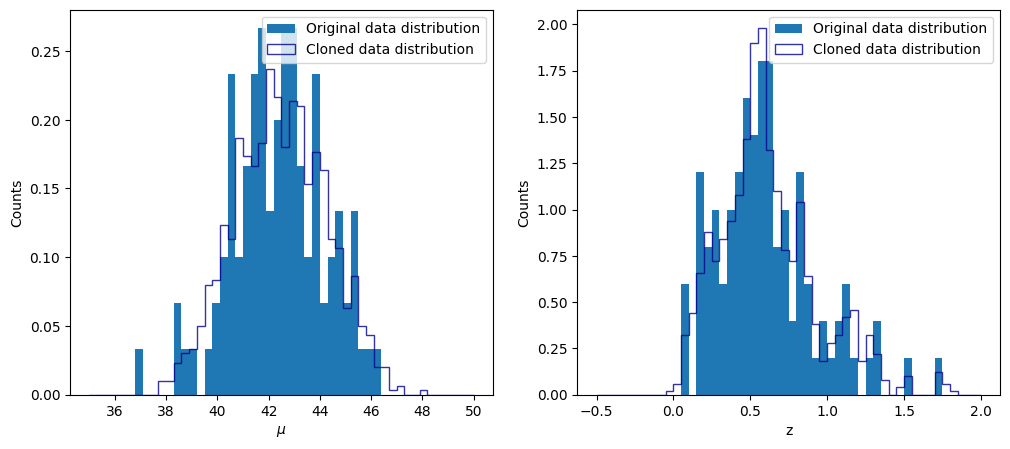

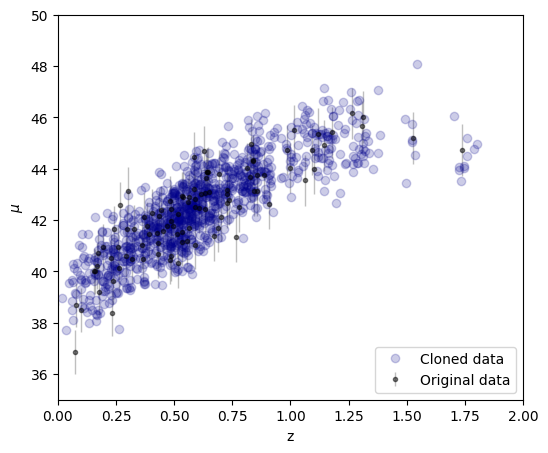

In [18]:
fig,ax=plt.subplots(1,2,figsize=(12,5))


N = 10*len(z_sample)
z_sampled = scaler.inverse_transform(kde.sample(N, random_state=42))

mu_pred, dmu_sampled = grid.best_estimator_.predict(z_sampled, return_std=True)
mu_sampled = np.random.normal(loc=mu_pred, scale=dmu_sampled)

ax[0].hist(mu_sample, bins=Nbins, range=(35,50), density=True, label='Original data distribution')
ax[0].hist(mu_sampled, bins=Nbins, range=(35,50), color = 'darkblue', alpha = 0.8, histtype='step', label = 'Cloned data distribution', density=True)
ax[0].set(xlabel=r'$\mu$', ylabel='Counts')
ax[0].legend()

ax[1].hist(z_sample, bins=Nbins, range=(-0.5,2), density=True, label='Original data distribution')
ax[1].hist(z_sampled, bins=Nbins, range=(-0.5,2), color = 'darkblue', alpha = 0.8, histtype='step', label = 'Cloned data distribution', density=True)
ax[1].set(xlabel='z',ylabel='Counts')
ax[1].legend()

fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', alpha=0.5, lw=1,label='Original data')
ax.plot(z_sampled,mu_sampled, color='darkblue', marker='o', linestyle='', alpha=0.2, label='Cloned data')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

In [ ]:
import emcee
from scipy.stats import norm
# now let's initialize an MCMC to fit the datas and let's find the best values for H0 and Om

def model_tofit(z, H0, Om):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

def log_likelihood(x,z,mu,mu_err):
    H0, Om = x
    if Om<0:
        return -np.inf
    else:
        return np.sum(norm(loc=model_tofit(z,H0,Om), scale=mu_err).logpdf(mu))

def log_prior(x):
    H0, Om = x
    if (0.1 < Om < 1) & (50 < H0 < 100):
        return 0
    else:
        return -np.inf

def log_posterior(x, z, mu, mu_err):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(x,z,mu,mu_err) + lp

In [14]:
ndim=2
nwalkers=5
# creating the MCMC with emcee (it takes a while)
starting_guesses = np.column_stack([np.random.uniform(50, 100, size=nwalkers),np.random.uniform(0.1, 1, size=nwalkers)])

nsteps=int(1e4)

sampler=emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[z_sample,mu_sample,dmu])
sampler.run_mcmc(starting_guesses, nsteps)

State([[59.3164294   0.4960231 ]
 [61.80376369  0.49719267]
 [64.02977758  0.45268136]
 [61.22449408  0.90966385]
 [71.68439579  0.24467503]], log_prob=[-135.26160542 -133.64114594 -133.11933079 -133.85971349 -132.87817522], blobs=None, random_state=('MT19937', array([2756435872,   32267097, 2283943389, 3174787450, 2436947301,
        866992049, 3585847059, 3293191784, 3207582515,  365146113,
       3649738658, 3494635059,  724613319, 1194607731, 1715690686,
       3388563176, 2312323296, 3419270973, 1890761055, 2910741068,
       1775400073, 1941934387, 1419092994,  102764724, 1500422565,
       2000747542,  521174614, 2226633952,  525347834,  176257012,
        552835024,  573580899,  553403656, 3805951250, 2746208778,
       3269788042, 1539991027,  791873064, 1301850522, 2616399337,
       3273383594, 3339102065, 3735360145, 1407505597, 3371929565,
       2168916805,  249168058,  268029424, 1829569365, 1019755452,
       2599655074,  159798566, 2232044925, 1475189890, 2903790940,
 

[43.86223347 42.6715278 ]


/home/giacomo/myenv/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (10000) than draws (5). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


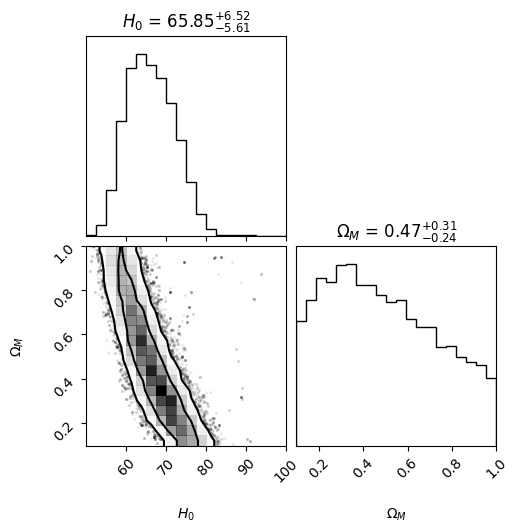

In [17]:
import corner

# plotting the results
emcee_trace = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.max(tau)+1)
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)

ranges=([50,100],[0.1,1])
labels = [r'$H_0$',r'$\Omega_M$']
fig = corner.corner(emcee_trace, labels=labels,range=ranges,
                    levels=[0.68,0.95],
                    show_titles=True, title_fmt=".2f", 
                    title_kwargs={"fontsize": 12})

/home/giacomo/myenv/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1471: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


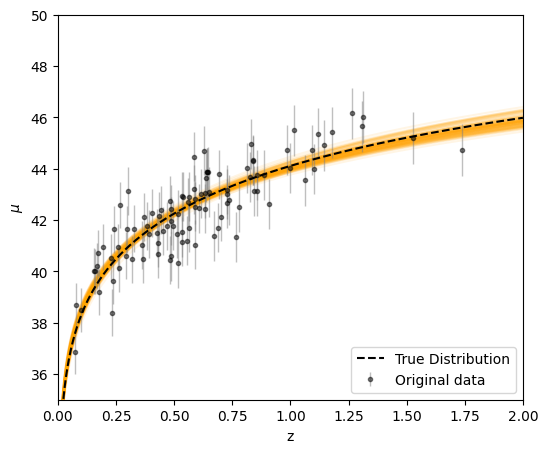

In [18]:
N=100
fig,ax = plt.subplots(1,1,figsize=(6,5))
index = np.random.choice(len(flat_samples), N, replace=False)

for i in index:
    sample = flat_samples[i]
    ygrid = model_tofit(xgrid, *sample)
    ax.plot(xgrid, ygrid, color='orange', alpha=0.1)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', alpha=0.5, lw=1,label='Original data')
ax.plot(xgrid, mu_true,linestyle='--',marker='',color='black',label='True Distribution')
ax.set(xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')

In [30]:
# let's do the same but this time we fix Om=1
def log_likelihood2(x,z,mu,mu_err):
    H0 = x[0]
    Om=1
    return np.sum(norm(loc=model_tofit(z,H0,Om), scale=mu_err).logpdf(mu))

def log_prior2(x):
    H0 = x[0]
    if (50 < H0 < 100):
        return 0
    else:
        return -np.inf

def log_posterior2(x, z, mu, mu_err):
    lp = log_prior2(x)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood2(x,z,mu,mu_err) + lp

In [31]:
ndim=1
nwalkers=5
starting_guesses = np.column_stack([np.random.uniform(50, 100, size=nwalkers)])

nsteps=int(1e4)

sampler=emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[z_sample,mu_sample,dmu])
sampler.run_mcmc(starting_guesses, nsteps)

State([[61.10046519]
 [56.72234416]
 [61.88752909]
 [56.10732876]
 [58.64695139]], log_prob=[-134.44427118 -133.59346868 -134.88478245 -133.71372443 -133.61479386], blobs=None, random_state=('MT19937', array([4157450029, 4018334863,  166206609, 1169481125, 3393984291,
        419738884, 4220962566, 1444883402, 1819824925,  678544782,
       3512732983,  740822267, 3005174166, 1671145669, 4146832597,
       3838524873,  274715188,  507027067, 3591380469, 2027228876,
       1183267074, 2742775650, 4020107150, 1945828764, 3870480288,
       1122830137,  401524994, 2866489036,   68706036, 1270022787,
        480656546, 2141079194,  105801222, 3219445560, 4293953948,
       3763457883, 2186335232,   19268980, 4070373959, 2435027829,
        462830449, 2763366921, 4239767025, 2352196811, 1178853215,
       2721979567, 4193790565, 2908352624, 2353160686, 2121708920,
       2951802381, 2933445299, 1358693501, 1692690003, 1074756413,
       1958068679, 2065276538, 3623833882,  216274686, 404416

[29.32018563]


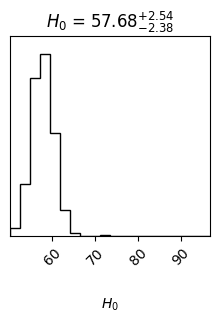

In [44]:
# plotting the results
emcee_trace = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)
thin = int(np.max(tau)+1)
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)


label = [r'$H_0$']
fig = corner.corner(emcee_trace, labels=label,
                    levels=[0.68,0.95],
                    show_titles=True, 
                    title_kwargs={"fontsize": 12})

/home/giacomo/myenv/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1471: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


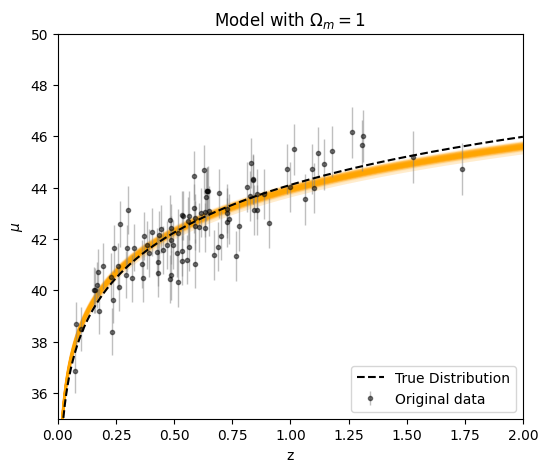

In [47]:
N=100
fig,ax = plt.subplots(1,1,figsize=(6,5))
index = np.random.choice(len(flat_samples), N, replace=False)

for i in index:
    sample = flat_samples[i]
    ygrid = model_tofit(xgrid, *sample,1)
    ax.plot(xgrid, ygrid, color='orange', alpha=0.1)

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', alpha=0.5, lw=1,label='Original data')
ax.plot(xgrid, mu_true,linestyle='--',marker='',color='black',label='True Distribution')
ax.set(title=r'Model with $\Omega_m = 1$',xlabel='z',ylabel=r'$\mu$',xlim=(0,2),ylim=(35,50))
ax.legend(loc='lower right')